In [1]:
# Data manipulation
import pandas as pd
import numpy as np
# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 18
%matplotlib inline
MAX_EVALS = 20
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
import json
import shlex
import subprocess
import logging
from pprint import pprint
import re
import os

In [2]:
file_suffix = "BT-IO-400-400-400-16-" + str(MAX_EVALS)
project_dir = "/home/dsinghvi/project/progress/"
def runthebenchmark(hyperparameters):
    os.chdir(project_dir+'active/../')
    storeinfile(hyperparameters)
    out=subprocess.Popen(["python3","bt_read_config_general.py","-n16","-p4","-c400 400 400"], shell=False, stdout=subprocess.PIPE)
    logging.basicConfig(level=logging.DEBUG)
    output=out.stdout.read().decode('utf-8')
    print("output"+output)
    if len(output.split(" ")) > 5:
        values = output.split(" ")
        value = float(float(values[6])*1024)/float(values[5]) + float(float(values[3])*1024)/float(values[2])
        value = float(value)
        print(value)
        return float((value/1000)**3),output
    return 0,0;

In [3]:
def storeinfile(hyperparameters):
    data={"mpi": {"romio_ds_read": "enable", "romio_ds_write": "disable"}, "lfs": {"setstripe": {"size": "16777216", "count": 4}}}
    data["lfs"]["setstripe"]["size"] = int(hyperparameters["setstripe-size"])
    data["lfs"]["setstripe"]["count"] = int(hyperparameters["setstripe-count"])

    data["mpi"]["romio_ds_read"] = hyperparameters["romio_ds_read"]
    data["mpi"]["romio_ds_write"] = hyperparameters["romio_ds_write"]
    data["mpi"]["romio_cb_read"] = hyperparameters["romio_cb_read"]
    data["mpi"]["romio_cb_write"] = hyperparameters["romio_cb_write"]
    data["mpi"]["cb_buffer_size"] = str(int(hyperparameters["cb_buffer_size"]))
    with open("confex.json","w") as fp:
        json.dump(data,fp)
    print(data)


In [4]:
def objective(hyperparameters):
    global ITERATION
    ITERATION += 1
    start = timer()
    result=0
    while(result == 0):
        print("rerun")
        result,output = runthebenchmark(hyperparameters)
        print(result)
    run_time = timer() - start
    print({'loss': result, 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK})
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([float(result), hyperparameters, ITERATION, run_time, output])
    return {'loss': float(result), 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK}


In [5]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

space = {
    'romio_ds_read' : hp.choice('romio_ds_read',['enable','disable']),
    'romio_ds_write' : hp.choice('romio_ds_write',['enable','disable']),
    'romio_cb_read' : hp.choice('romio_cb_read',['enable','disable']),
    'romio_cb_write' : hp.choice('romio_cb_write',['enable','disable']),
    'cb_buffer_size' : 1048576*hp.quniform('cb_buffer_size',1,256,1),
    'setstripe-size' : 65536*(hp.quniform('setstripe-size',0,156,1)),
    'setstripe-count' : hp.quniform('setstripe-count',0,30,1)
    
}

In [6]:
x = sample(space)
params = x
print(x)

cb_buffer_size_dist = []
for _ in range(1000):
    cb_buffer_size_dist.append(sample(space)['cb_buffer_size'])
    
setstripe_size_dist = []
for _ in range(1000):
    setstripe_size_dist.append(sample(space)['setstripe-size'])
    
setstripe_count_dist = []
for _ in range(1000):
    setstripe_count_dist.append(sample(space)['setstripe-count']) 
    
romio_ds_read_dist = []
for _ in range(20):
    romio_ds_read_dist.append(sample(space)['romio_ds_read'])
    
romio_ds_write_dist = []
for _ in range(20):
    romio_ds_write_dist.append(sample(space)['romio_ds_write'])
    
romio_cb_read_dist = []
for _ in range(20):
    romio_cb_read_dist.append(sample(space)['romio_cb_read']) 
    
romio_cb_write_dist = []
for _ in range(20):
    romio_cb_write_dist.append(sample(space)['romio_cb_write']) 
    

{'cb_buffer_size': 91226112.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 10.0, 'setstripe-size': 9830400.0}


In [7]:
# File to save first results
print(os.getcwd())
out_file = project_dir+'active/result/gbm_trials-'+file_suffix+'.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
writer.writerow(['loss', 'params', 'iteration', 'train_time', 'output'])
of_connection.close()

/home/dsinghvi/project/progress/active


In [8]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest


from hyperopt import Trials

# Record results
bayes_trials = Trials()

from hyperopt import fmin


ITERATION = 20

best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = bayes_trials, max_evals = MAX_EVALS)

rerun                                               
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '228589568'}, 'lfs': {'setstripe': {'size': 3211264, 'count': 18}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 1045.84 1029.97 0.98 50.63 1029.97 20.34 3211264 18 disable enable enable disable 228589568 

21839.77248939806                                   
10417.039949548453                                  
{'loss': 10417.039949548453, 'hyperparameters': {'cb_buffer_size': 228589568.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 18.0, 'setstripe-size': 3211264.0}, 'iteration': 21, 'iteration_time': 30.79224648606032, 'status': 'ok'}
  5%|▌         | 1/20 [00:30<09:45, 30.81s/it, best loss: 10417.039949548453]

INFO:hyperopt.tpe:tpe_transform took 0.011338 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 10417.039950


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '236978176'}, 'lfs': {'setstripe': {'size': 3211264, 'count': 20}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 1152.22 1029.97 0.89 624.24 1029.97 1.65 3211264 20 enable enable enable enable 236978176 

2604.9114314230696                                                           
17.675792100571446                                                           
{'loss': 17.675792100571446, 'hyperparameters': {'cb_buffer_size': 236978176.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 20.0, 'setstripe-size': 3211264.0}, 'iteration': 22, 'iteration_time': 13.04855452850461, 'status': 'ok'}
 10%|█         | 2/20 [00:43<07:38, 25.49s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.009358 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 17.675792


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '227540992'}, 'lfs': {'setstripe': {'size': 6553600, 'count': 11}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 993.26 1029.97 1.04 592.61 1029.97 1.74 6553600 11 disable disable enable enable 227540992 

2841.5820031266485                                                           
22.94460474050699                                                            
{'loss': 22.94460474050699, 'hyperparameters': {'cb_buffer_size': 227540992.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 11.0, 'setstripe-size': 6553600.0}, 'iteration': 23, 'iteration_time': 11.657011516392231, 'status': 'ok'}
 15%|█▌        | 3/20 [00:55<06:02, 21.35s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.011064 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 17.675792


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '204472320'}, 'lfs': {'setstripe': {'size': 5963776, 'count': 17}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 590.93 1029.97 1.74 486.36 1029.97 2.12 5963776 17 disable disable enable enable 204472320 

3953.331855539901                                                            
61.78596241511858                                                            
{'loss': 61.78596241511858, 'hyperparameters': {'cb_buffer_size': 204472320.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 17.0, 'setstripe-size': 5963776.0}, 'iteration': 24, 'iteration_time': 12.543139370158315, 'status': 'ok'}
 20%|██        | 4/20 [01:08<04:59, 18.72s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.009690 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 17.675792


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '170917888'}, 'lfs': {'setstripe': {'size': 7274496, 'count': 6}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 1212.19 1029.97 0.85 36.78 1029.97 28.00 7274496 6 enable disable enable disable 170917888 

29545.688637915315                                                           
25791.84144627989                                                            
{'loss': 25791.84144627989, 'hyperparameters': {'cb_buffer_size': 170917888.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 6.0, 'setstripe-size': 7274496.0}, 'iteration': 25, 'iteration_time': 39.56279798876494, 'status': 'ok'}
 25%|██▌       | 5/20 [01:47<06:14, 24.98s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.013795 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 17.675792


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '225443840'}, 'lfs': {'setstripe': {'size': 1179648, 'count': 2}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 52.85 1029.97 19.49 302.60 1029.97 3.40 1179648 2 enable enable disable enable 225443840 

23441.70169324073                                                            
12881.528689964814                                                           
{'loss': 12881.528689964814, 'hyperparameters': {'cb_buffer_size': 225443840.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 2.0, 'setstripe-size': 1179648.0}, 'iteration': 26, 'iteration_time': 31.623178127221763, 'status': 'ok'}
 30%|███       | 6/20 [02:19<06:17, 26.98s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.009893 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 17.675792


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '75497472'}, 'lfs': {'setstripe': {'size': 8060928, 'count': 22}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 621.18 1029.97 1.66 584.91 1029.97 1.76 8060928 22 disable disable enable enable 75497472 

3501.0453604769637                                                           
42.9134284728453                                                             
{'loss': 42.9134284728453, 'hyperparameters': {'cb_buffer_size': 75497472.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 22.0, 'setstripe-size': 8060928.0}, 'iteration': 27, 'iteration_time': 12.915864332579076, 'status': 'ok'}
 35%|███▌      | 7/20 [02:32<04:56, 22.77s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.009588 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 17.675792


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '221249536'}, 'lfs': {'setstripe': {'size': 9306112, 'count': 13}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 612.32 1029.97 1.68 598.57 1029.97 1.72 9306112 13 enable disable enable enable 221249536 

3484.46280599107                                                             
42.30653911560041                                                            
{'loss': 42.30653911560041, 'hyperparameters': {'cb_buffer_size': 221249536.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 13.0, 'setstripe-size': 9306112.0}, 'iteration': 28, 'iteration_time': 12.109493152238429, 'status': 'ok'}
 40%|████      | 8/20 [02:44<03:54, 19.58s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.009750 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 17.675792


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '230686720'}, 'lfs': {'setstripe': {'size': 2818048, 'count': 1}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 58.15 1029.97 17.71 20.32 1029.97 50.69 2818048 1 enable enable disable disable 230686720 

70041.39088564059                                                            
343608.80586296483                                                           
{'loss': 343608.80586296483, 'hyperparameters': {'cb_buffer_size': 230686720.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 1.0, 'setstripe-size': 2818048.0}, 'iteration': 29, 'iteration_time': 76.9648726945743, 'status': 'ok'}
 45%|████▌     | 9/20 [04:01<06:44, 36.81s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.009319 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 17.675792


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '79691776'}, 'lfs': {'setstripe': {'size': 9306112, 'count': 30}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 137.72 1029.97 7.48 817.37 1029.97 1.26 9306112 30 enable enable disable enable 79691776 

8948.5593324759                                                              
716.5712275137522                                                            
{'loss': 716.5712275137522, 'hyperparameters': {'cb_buffer_size': 79691776.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 30.0, 'setstripe-size': 9306112.0}, 'iteration': 30, 'iteration_time': 17.632734543643892, 'status': 'ok'}
 50%|█████     | 10/20 [04:19<05:10, 31.06s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.009405 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 17.675792


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '232783872'}, 'lfs': {'setstripe': {'size': 2686976, 'count': 22}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 945.96 1029.97 1.09 59.82 1029.97 17.22 2686976 22 enable enable enable disable 232783872 

18745.98848412123                                                             
6587.566884471661                                                             
{'loss': 6587.566884471661, 'hyperparameters': {'cb_buffer_size': 232783872.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 22.0, 'setstripe-size': 2686976.0}, 'iteration': 31, 'iteration_time': 26.88223846256733, 'status': 'ok'}
 55%|█████▌    | 11/20 [04:46<04:28, 29.82s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.009352 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 17.675792


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '198180864'}, 'lfs': {'setstripe': {'size': 7798784, 'count': 2}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 403.43 1029.97 2.55 1015.28 1029.97 1.01 7798784 2 enable disable enable enable 198180864 

3653.1216990181856                                                            
48.75199824373243                                                             
{'loss': 48.75199824373243, 'hyperparameters': {'cb_buffer_size': 198180864.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 2.0, 'setstripe-size': 7798784.0}, 'iteration': 32, 'iteration_time': 12.26285978127271, 'status': 'ok'}
 60%|██████    | 12/20 [04:58<03:16, 24.56s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.009584 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 17.675792


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '213909504'}, 'lfs': {'setstripe': {'size': 9371648, 'count': 21}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 593.65 1029.97 1.73 825.10 1029.97 1.25 9371648 21 disable enable enable enable 213909504 

3054.874315569589                                                             
28.508872471980226                                                            
{'loss': 28.508872471980226, 'hyperparameters': {'cb_buffer_size': 213909504.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 21.0, 'setstripe-size': 9371648.0}, 'iteration': 33, 'iteration_time': 11.675266052596271, 'status': 'ok'}
 65%|██████▌   | 13/20 [05:10<02:24, 20.70s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.010003 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 17.675792


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '156237824'}, 'lfs': {'setstripe': {'size': 7733248, 'count': 21}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 71.21 1029.97 14.46 80.50 1029.97 12.79 7733248 21 disable enable disable disable 156237824 

27912.701679103273                                                            
21747.313847684505                                                            
{'loss': 21747.313847684505, 'hyperparameters': {'cb_buffer_size': 156237824.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 21.0, 'setstripe-size': 7733248.0}, 'iteration': 34, 'iteration_time': 35.7078647185117, 'status': 'ok'}
 70%|███████   | 14/20 [05:45<02:31, 25.21s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.009389 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 17.675792


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '75497472'}, 'lfs': {'setstripe': {'size': 2555904, 'count': 27}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 72.92 1029.97 14.13 1166.44 1029.97 0.88 2555904 27 disable enable disable enable 75497472 

15367.843985373878                                                            
3629.4333766927707                                                            
{'loss': 3629.4333766927707, 'hyperparameters': {'cb_buffer_size': 75497472.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 27.0, 'setstripe-size': 2555904.0}, 'iteration': 35, 'iteration_time': 23.634862054139376, 'status': 'ok'}
 75%|███████▌  | 15/20 [06:09<02:03, 24.75s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.009353 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 17.675792


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '253755392'}, 'lfs': {'setstripe': {'size': 196608, 'count': 9}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 137.37 1029.97 7.50 1138.78 1029.97 0.90 196608 9 enable disable disable enable 253755392 

8603.88361802343                                                              
636.9180863538281                                                             
{'loss': 636.9180863538281, 'hyperparameters': {'cb_buffer_size': 253755392.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 9.0, 'setstripe-size': 196608.0}, 'iteration': 36, 'iteration_time': 17.106191247701645, 'status': 'ok'}
 80%|████████  | 16/20 [06:26<01:29, 22.46s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.009684 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 17.675792


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '210763776'}, 'lfs': {'setstripe': {'size': 10027008, 'count': 30}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 1227.55 1029.97 0.84 529.58 1029.97 1.94 10027008 30 disable disable enable enable 210763776 

2850.7403281549878                                                            
23.16716963285582                                                             
{'loss': 23.16716963285582, 'hyperparameters': {'cb_buffer_size': 210763776.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 30.0, 'setstripe-size': 10027008.0}, 'iteration': 37, 'iteration_time': 13.315546119585633, 'status': 'ok'}
 85%|████████▌ | 17/20 [06:39<00:59, 19.73s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.009325 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 17.675792


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '173015040'}, 'lfs': {'setstripe': {'size': 1703936, 'count': 9}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 124.58 1029.97 8.27 1216.88 1029.97 0.85 1703936 9 disable enable disable enable 173015040 

9332.675794408611                                                             
812.8652123037671                                                             
{'loss': 812.8652123037671, 'hyperparameters': {'cb_buffer_size': 173015040.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 9.0, 'setstripe-size': 1703936.0}, 'iteration': 38, 'iteration_time': 17.836434362456203, 'status': 'ok'}
 90%|█████████ | 18/20 [06:57<00:38, 19.17s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.009485 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 17.675792


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '248512512'}, 'lfs': {'setstripe': {'size': 10092544, 'count': 28}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 134.83 1029.97 7.64 36.28 1029.97 28.39 10092544 28 enable enable disable disable 248512512 

36893.18165052631                                                             
50215.5623476332                                                              
{'loss': 50215.5623476332, 'hyperparameters': {'cb_buffer_size': 248512512.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 28.0, 'setstripe-size': 10092544.0}, 'iteration': 39, 'iteration_time': 44.69447594694793, 'status': 'ok'}
 95%|█████████▌| 19/20 [07:42<00:26, 26.84s/it, best loss: 17.675792100571446]

INFO:hyperopt.tpe:tpe_transform took 0.010967 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 17.675792


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '148897792'}, 'lfs': {'setstripe': {'size': 7536640, 'count': 16}}}
outputbtio-pnetcdf-1.1.1 300-300-30016 556.78 1029.97 1.85 51.77 1029.97 19.90 7536640 16 enable enable enable disable 148897792 

22266.861454106165                                                            
11040.202028265518                                                            
{'loss': 11040.202028265518, 'hyperparameters': {'cb_buffer_size': 148897792.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 16.0, 'setstripe-size': 7536640.0}, 'iteration': 40, 'iteration_time': 33.49300763104111, 'status': 'ok'}
100%|██████████| 20/20 [08:16<00:00, 28.84s/it, best loss: 17.675792100571446]


In [9]:
print(best)
d=  best
#print(bayes_trials.results)
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
#bayes_trials_results[:1]

{'cb_buffer_size': 226.0, 'romio_cb_read': 0, 'romio_cb_write': 0, 'romio_ds_read': 0, 'romio_ds_write': 0, 'setstripe-count': 20.0, 'setstripe-size': 49.0}


In [10]:
results = pd.read_csv(out_file)

# Sort with best scores on top and reset index for slicing
results.sort_values('train_time', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()


,loss,params,iteration,train_time,output
0,22.944605,"{'cb_buffer_size': 227540992.0, 'romio_cb_read...",23,11.657012,btio-pnetcdf-1.1.1 300-300-30016 993.26 1029.9...
1,28.508872,"{'cb_buffer_size': 213909504.0, 'romio_cb_read...",33,11.675266,btio-pnetcdf-1.1.1 300-300-30016 593.65 1029.9...
2,42.306539,"{'cb_buffer_size': 221249536.0, 'romio_cb_read...",28,12.109493,btio-pnetcdf-1.1.1 300-300-30016 612.32 1029.9...
3,48.751998,"{'cb_buffer_size': 198180864.0, 'romio_cb_read...",32,12.262860,btio-pnetcdf-1.1.1 300-300-30016 403.43 1029.9...
4,61.785962,"{'cb_buffer_size': 204472320.0, 'romio_cb_read...",24,12.543139,btio-pnetcdf-1.1.1 300-300-30016 590.93 1029.9...


In [11]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()
print(best_bayes_params)
log = open('bt_best.txt','a')
print(results.loc[0,'output'])
print(results.loc[0,'output'],file=log)
log.close()

{'cb_buffer_size': 227540992.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 11.0, 'setstripe-size': 6553600.0}
btio-pnetcdf-1.1.1 300-300-30016 993.26 1029.97 1.04 592.61 1029.97 1.74 6553600 11 disable disable enable enable 227540992 



In [12]:
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
bayes_params['train_time'] = results['train_time']    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']
bayes_params['output']=results['output']

bayes_params.head()

,cb_buffer_size,romio_cb_read,romio_cb_write,romio_ds_read,romio_ds_write,setstripe-count,setstripe-size,train_time,loss,iteration,output
0,2.27541e+08,enable,enable,disable,disable,11,6.5536e+06,11.657012,22.944605,23,btio-pnetcdf-1.1.1 300-300-30016 993.26 1029.9...
1,2.1391e+08,enable,enable,disable,enable,21,9.37165e+06,11.675266,28.508872,33,btio-pnetcdf-1.1.1 300-300-30016 593.65 1029.9...
2,2.2125e+08,enable,enable,enable,disable,13,9.30611e+06,12.109493,42.306539,28,btio-pnetcdf-1.1.1 300-300-30016 612.32 1029.9...
3,1.98181e+08,enable,enable,enable,disable,2,7.79878e+06,12.262860,48.751998,32,btio-pnetcdf-1.1.1 300-300-30016 403.43 1029.9...
4,2.04472e+08,enable,enable,disable,disable,17,5.96378e+06,12.543139,61.785962,24,btio-pnetcdf-1.1.1 300-300-30016 590.93 1029.9...


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0 to DejaVu Sans ('/home/dsinghvi/project/progress/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=21.599999999999998 to DejaVu Sans ('/home/dsinghvi/project/progress/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


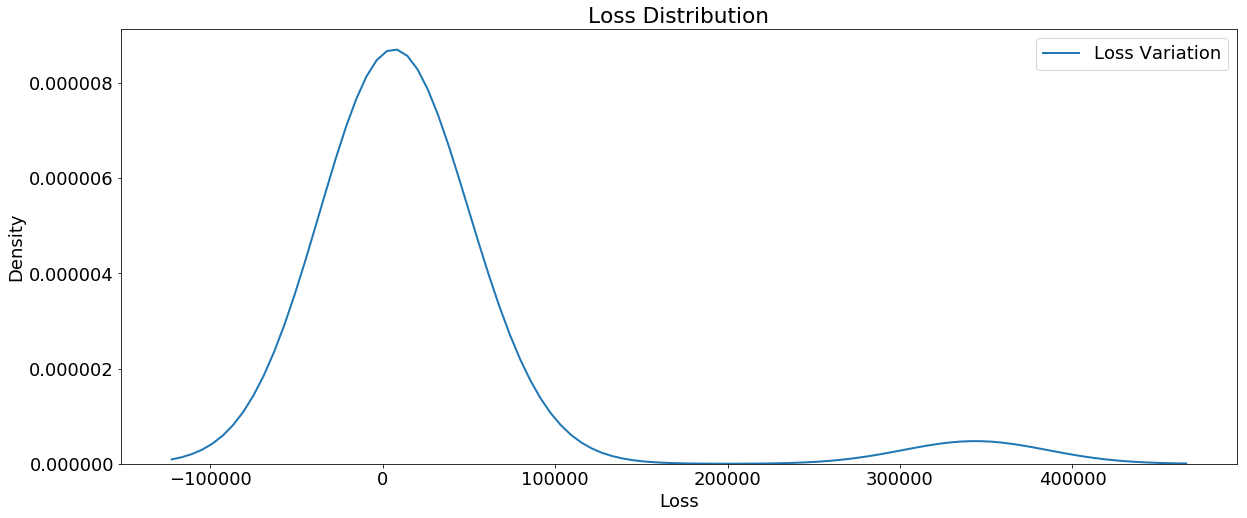

In [13]:
os.chdir('./bt_plots')
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['loss'], label = 'Loss Variation', linewidth = 2)
plt.legend()
plt.xlabel('Loss'); plt.ylabel('Density'); plt.title('Loss Distribution');
plt.savefig(file_suffix+'_loss.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


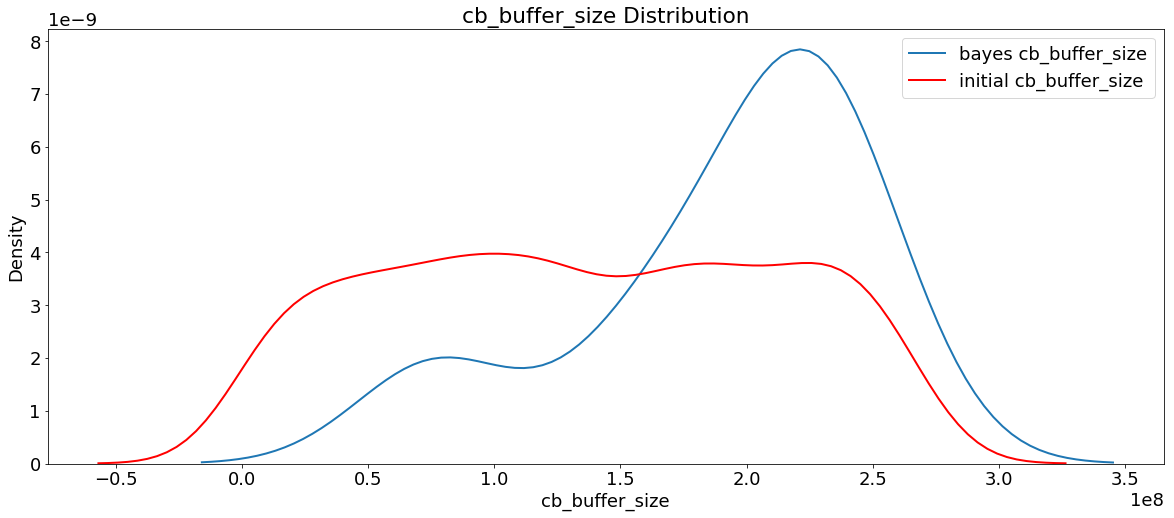

In [14]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18


sns.kdeplot(bayes_params['cb_buffer_size'], label = 'bayes cb_buffer_size', linewidth = 2)
sns.kdeplot(cb_buffer_size_dist,color="red",linewidth=2, label = 'initial cb_buffer_size')

plt.legend()
plt.xlabel('cb_buffer_size'); plt.ylabel('Density'); plt.title('cb_buffer_size Distribution');
plt.savefig(file_suffix+'_cb_buffer_size.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


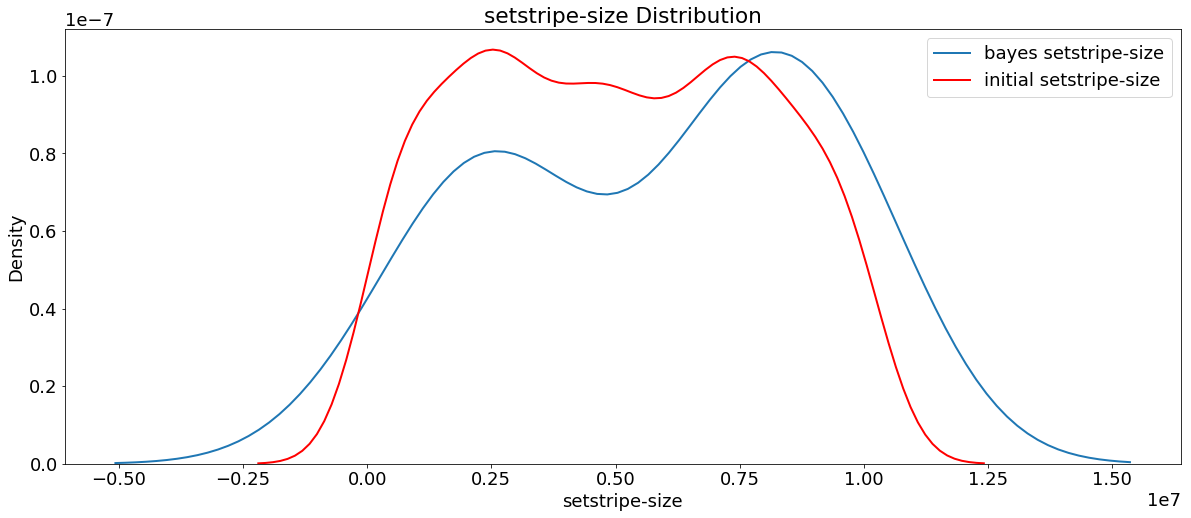

In [15]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-size'], label = 'bayes setstripe-size', linewidth = 2)
sns.kdeplot(setstripe_size_dist,color="red",linewidth=2, label = 'initial setstripe-size')

plt.legend()
plt.xlabel('setstripe-size'); plt.ylabel('Density'); plt.title('setstripe-size Distribution');
plt.savefig(file_suffix+'_setstripe-size.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


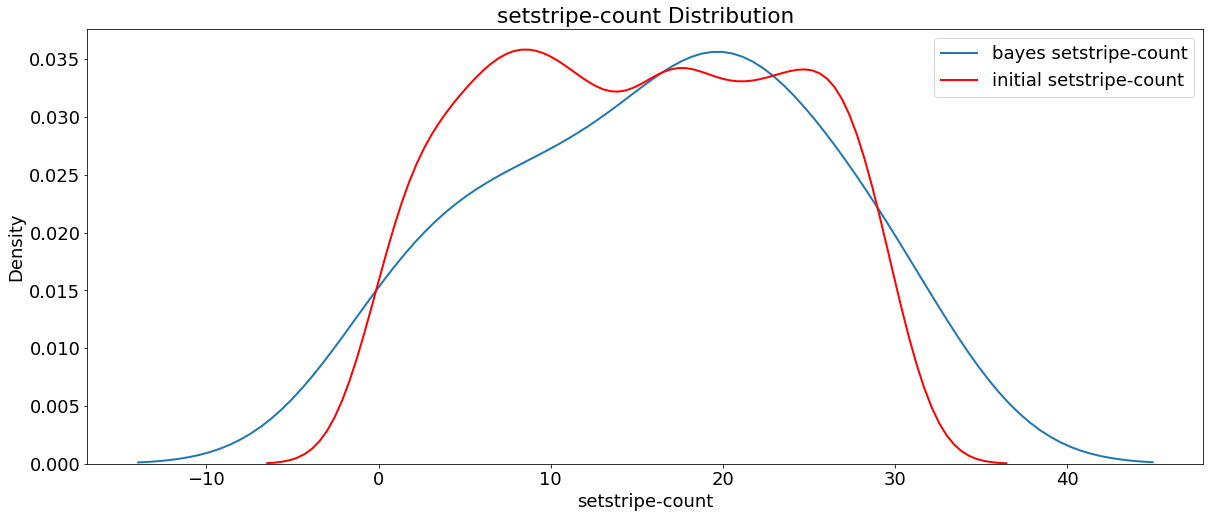

In [16]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-count'], label = 'bayes setstripe-count', linewidth = 2)
sns.kdeplot(setstripe_count_dist,color="red",linewidth=2, label = 'initial setstripe-count')

plt.legend()
plt.xlabel('setstripe-count'); plt.ylabel('Density'); plt.title('setstripe-count Distribution');
plt.savefig(file_suffix+'_setstripe-count.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


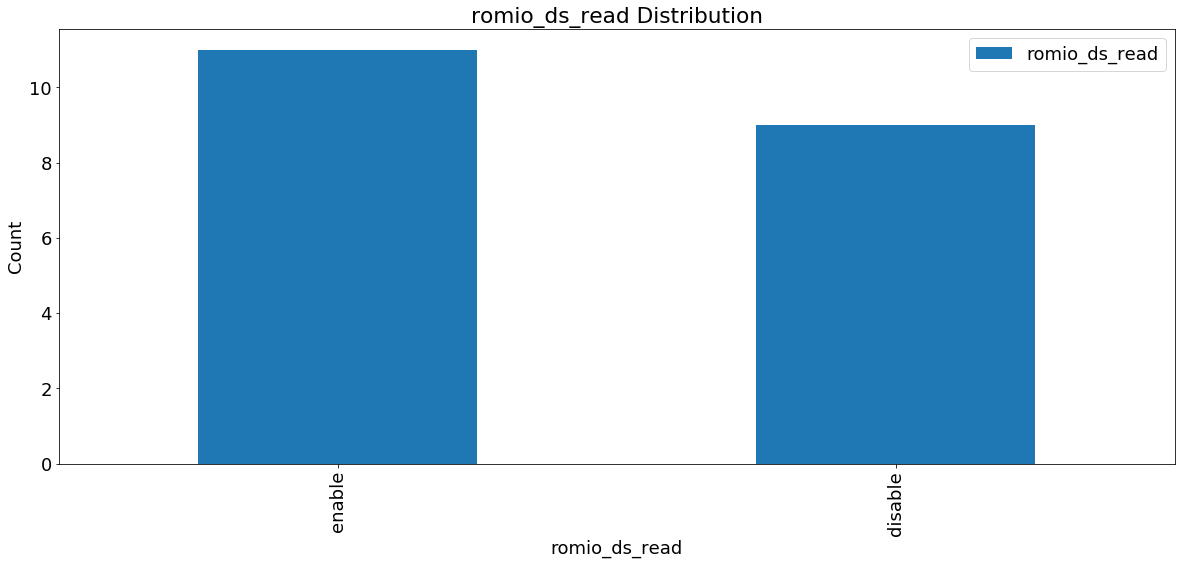

In [17]:
plt.figure(figsize = (20, 8))
from scipy.stats import itemfreq
plt.rcParams['font.size'] = 18
bayes_params['romio_ds_read'].value_counts().plot.bar()#plt.hist(romio_ds_read_dist,color="red",linewidth=2, label = 'initial romio_ds_read')

plt.legend()
plt.xlabel('romio_ds_read'); plt.ylabel('Count'); plt.title('romio_ds_read Distribution');
plt.savefig(file_suffix+'_romio_ds_read.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


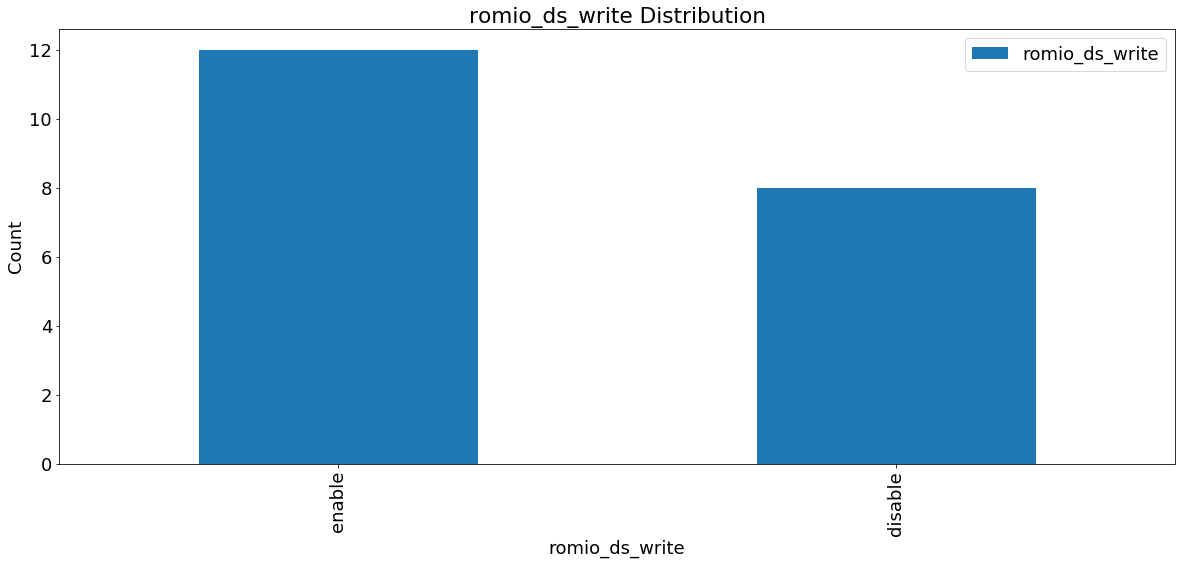

In [18]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

#plt.hist(bayes_params['romio_ds_write'], label = 'bayes romio_ds_write', linewidth = 2)
#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_ds_write')
bayes_params['romio_ds_write'].value_counts().plot.bar()
plt.legend()
plt.xlabel('romio_ds_write'); plt.ylabel('Count'); plt.title('romio_ds_write Distribution');
plt.savefig(file_suffix+'_romio_ds_write.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


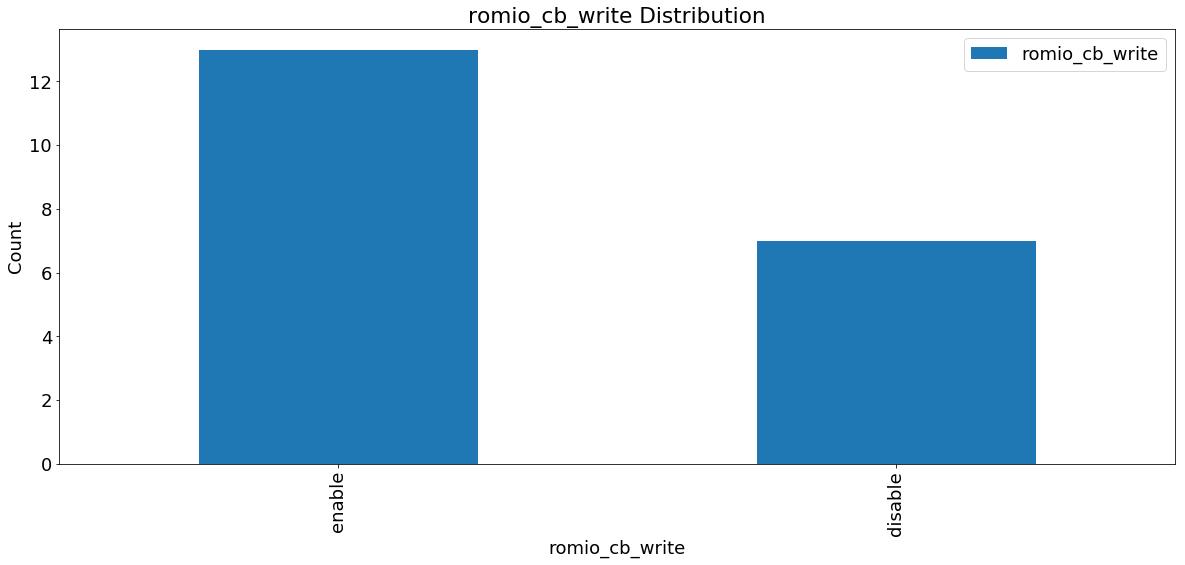

In [19]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

bayes_params['romio_cb_write'].value_counts().plot.bar()#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_cb_write')

plt.legend()
plt.xlabel('romio_cb_write'); plt.ylabel('Count'); plt.title('romio_cb_write Distribution');
plt.savefig(file_suffix+'_romio_cb_write.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


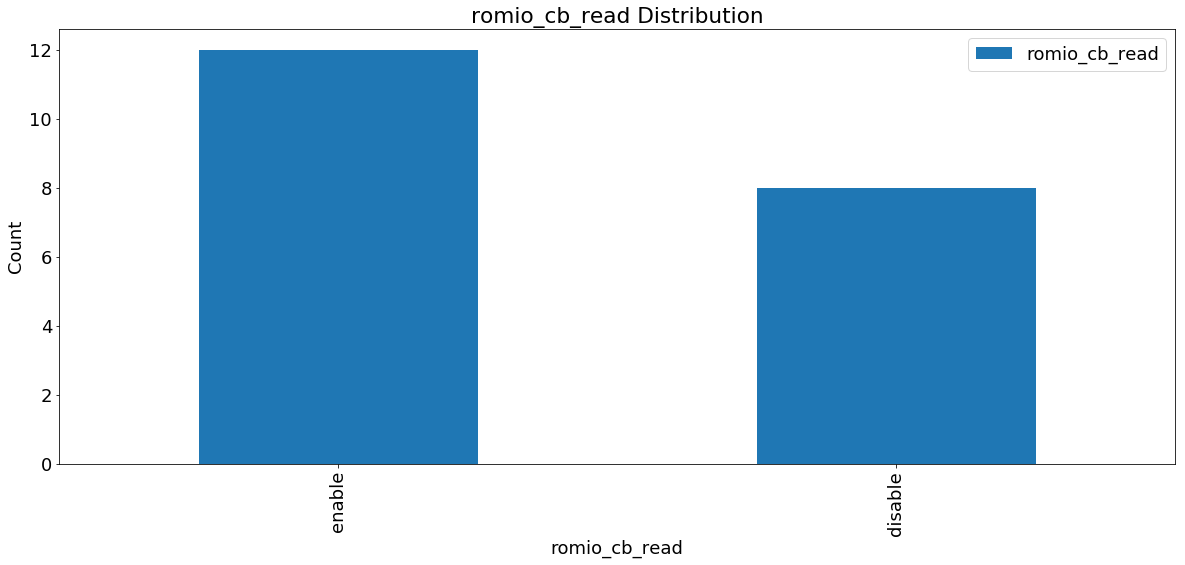

In [20]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

bayes_params['romio_cb_read'].value_counts().plot.bar()#plt.hist(romio_cb_read_dist,color="red",linewidth=2, label = 'initial romio_cb_read')

plt.legend()
plt.xlabel('romio_cb_read'); plt.ylabel('Count'); plt.title('romio_cb_read Distribution');
plt.savefig(file_suffix+'_romio_cb_read.png')

In [21]:
os.chdir('../')